* 15.01.23
* Yaromir Kapustin
* ver0.1

## ДЗ 22

ДЗ - построение ассоциативных правил для датасета :
Можно использовать например apriori, association_rules, fpgrowth из mlxtend.frequent_patterns (работают чуть быстрее)


https://www.kaggle.com/datasets/gorkhachatryan01/purchase-behaviour?select=dataset.csv

In [128]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
import collections
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [129]:
df = pd.read_csv("dataset.csv", skipinitialspace=True, header=None)

In [130]:
#Заменим NaN на последнее значение внутри транзакции, чтобы потом было легче обрабатывать весь датасет.
df = df.replace(r'^\s*$', np.nan, regex=True)
df.fillna(method = 'ffill', axis = 1, inplace = True)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,pork,sandwich bags,lunch meat,all- purpose,flour,soda,butter,vegetables,beef,aluminum foil,all- purpose,dinner rolls,shampoo,all- purpose
1,shampoo,hand soap,waffles,vegetables,cheeses,mixes,milk,sandwich bags,laundry detergent,dishwashing liquid/detergent,waffles,individual meals,hand soap,vegetables
2,pork,soap,ice cream,toilet paper,dinner rolls,hand soap,spaghetti sauce,milk,ketchup,sandwich loaves,poultry,toilet paper,ice cream,ketchup
3,juice,lunch meat,soda,toilet paper,all- purpose,all- purpose,all- purpose,all- purpose,all- purpose,all- purpose,all- purpose,all- purpose,all- purpose,all- purpose
4,pasta,tortillas,mixes,hand soap,toilet paper,vegetables,vegetables,paper towels,vegetables,flour,vegetables,pork,poultry,eggs


## Алгоритм Apriori от mlxtend

In [131]:
basket = df[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]].T.agg(', '.join)

In [132]:
basket.to_frame(name = 'Products')

,Products
0,"pork, sandwich bags, lunch meat, all- purpose,..."
1,"shampoo, hand soap, waffles, vegetables, chees..."
2,"pork, soap, ice cream, toilet paper, dinner ro..."
3,"juice, lunch meat, soda, toilet paper, all- pu..."
4,"pasta, tortillas, mixes, hand soap, toilet pap..."
...,...
1494,"beef, sandwich bags, hand soap, paper towels, ..."
1495,"dinner rolls, lunch meat, spaghetti sauce, pas..."
1496,"lunch meat, eggs, poultry, vegetables, tortill..."
1497,"ketchup, milk, poultry, cheeses, soap, toilet ..."


In [133]:
basket = basket.transform(lambda x: x.split(", "))

In [134]:
encoder = TransactionEncoder()
transactions = pd.DataFrame(encoder.fit(basket).transform(basket), columns=encoder.columns_)
display(transactions.head())

,all- purpose,aluminum foil,bagels,beef,butter,cereals,cheeses,coffee/tea,dinner rolls,dishwashing liquid/detergent,...,shampoo,soap,soda,spaghetti sauce,sugar,toilet paper,tortillas,vegetables,waffles,yogurt
0,True,True,False,True,True,False,False,False,True,False,...,True,False,True,False,False,False,False,True,False,False
1,False,False,False,False,False,False,True,False,False,True,...,True,False,False,False,False,False,False,True,True,False
2,False,False,False,False,False,False,False,False,True,False,...,False,True,False,True,False,True,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,True,False,False


In [135]:
%%time

frequent_itemsets = apriori(transactions, min_support= 4/len(basket), use_colnames=True, max_len = 2)
rules = association_rules(frequent_itemsets, metric="lift",  min_threshold = 1.15)
rules.nlargest(n = 10, columns = "lift")

CPU times: total: 15.6 ms
Wall time: 16 ms


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(butter),(sandwich loaves),0.261508,0.248833,0.078719,0.301020,1.209731,0.013648,1.074663
3,(sandwich loaves),(butter),0.248833,0.261508,0.078719,0.316354,1.209731,0.013648,1.080226
6,(fruits),(dishwashing liquid/detergent),0.263509,0.268179,0.084056,0.318987,1.189458,0.013389,1.074607
7,(dishwashing liquid/detergent),(fruits),0.268179,0.263509,0.084056,0.313433,1.189458,0.013389,1.072715
11,(hand soap),(mixes),0.237492,0.273516,0.076051,0.320225,1.170773,0.011093,1.068712
10,(mixes),(hand soap),0.273516,0.237492,0.076051,0.278049,1.170773,0.011093,1.056177
12,(ketchup),(soap),0.250167,0.265510,0.077385,0.309333,1.165052,0.010963,1.063450
13,(soap),(ketchup),0.265510,0.250167,0.077385,0.291457,1.165052,0.010963,1.058275
0,(fruits),(all- purpose),0.263509,0.263509,0.080720,0.306329,1.162500,0.011283,1.061730
1,(all- purpose),(fruits),0.263509,0.263509,0.080720,0.306329,1.162500,0.011283,1.061730


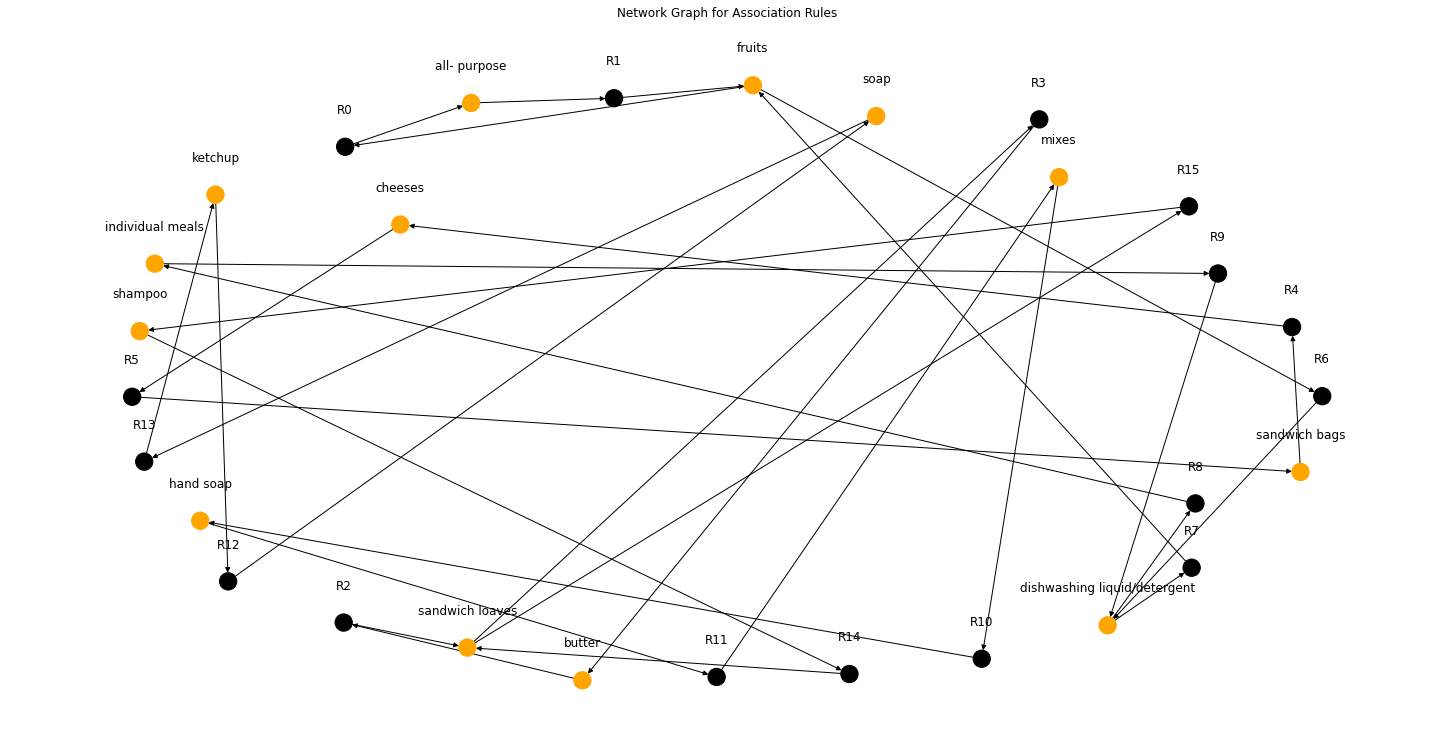

In [142]:
def draw_network(rules, rules_to_show):
  # Ориентированный граф от NetworkX
    network = nx.DiGraph()
    plt.figure (figsize=(20,10))

  
  # Перебор количества правил для отображения
    for i in range(rules_to_show):
    
    # Добавление узла правила
        network.add_nodes_from(["R"+str(i)])
        for antecedents in rules.iloc[i]['antecedents']: 
        # Добавление узла-предшественника и ссылки на правило
            network.add_nodes_from([antecedents])
            network.add_edge(antecedents, "R"+str(i),  weight = 2)
      
        for consequents in rules.iloc[i]['consequents']:
        # Добавление узла-последователя и ссылки на правило
            network.add_nodes_from([consequents])
            network.add_edge("R"+str(i), consequents,  weight = 2)

    color_map=[]  
  
  # Для каждого узла, если это правило, цвет черный, в противном случае - оранжевый.
    for node in network:
        if re.compile("^[R]\d+$").fullmatch(node) != None:
            color_map.append('black')
        else:
            color_map.append('orange')
  
  # Расположение узлов с помощью spring layout
    pos = nx.spring_layout(network, k=16, scale=1)
  # Построение сетевого графа
    nx.draw(network, pos, node_color = color_map, font_size=8)            
  
  # Сдвиг расположения текста вверх
    for p in pos:  
        pos[p][1] += 0.12

    nx.draw_networkx_labels(network, pos)
    plt.title("Network Graph for Association Rules")
    plt.show()

draw_network(rules, 16)

## Алгоритм apriori от FP-Growth

In [143]:
%%time

results = fpgrowth(transactions, min_support= 4/len(basket), use_colnames=True, max_len = 2)
rules = association_rules(results, metric="lift")
rules.nlargest(n = 10, columns = "lift")

CPU times: total: 812 ms
Wall time: 811 ms


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
980,(butter),(sandwich loaves),0.261508,0.248833,0.078719,0.301020,1.209731,0.013648,1.074663
981,(sandwich loaves),(butter),0.248833,0.261508,0.078719,0.316354,1.209731,0.013648,1.080226
1360,(fruits),(dishwashing liquid/detergent),0.263509,0.268179,0.084056,0.318987,1.189458,0.013389,1.074607
1361,(dishwashing liquid/detergent),(fruits),0.268179,0.263509,0.084056,0.313433,1.189458,0.013389,1.072715
671,(hand soap),(mixes),0.237492,0.273516,0.076051,0.320225,1.170773,0.011093,1.068712
670,(mixes),(hand soap),0.273516,0.237492,0.076051,0.278049,1.170773,0.011093,1.056177
872,(ketchup),(soap),0.250167,0.265510,0.077385,0.309333,1.165052,0.010963,1.063450
873,(soap),(ketchup),0.265510,0.250167,0.077385,0.291457,1.165052,0.010963,1.058275
1374,(fruits),(all- purpose),0.263509,0.263509,0.080720,0.306329,1.162500,0.011283,1.061730
1375,(all- purpose),(fruits),0.263509,0.263509,0.080720,0.306329,1.162500,0.011283,1.061730


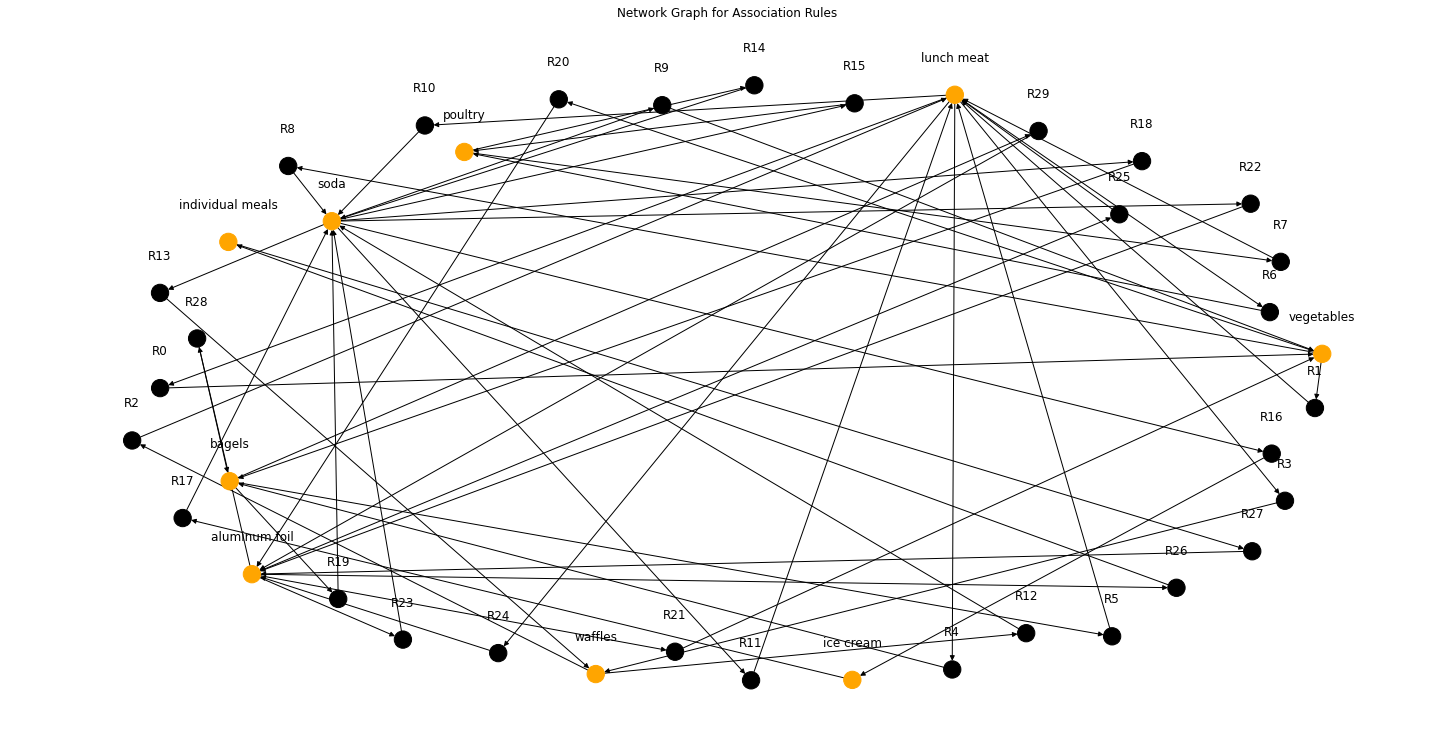

In [149]:
draw_network(rules, 30);

# Вывод

1. * Наиболее частое сочетание(max_len = 3) (juice)-(sandwichloaves, yogurt). Lift 1.577639
   * Наиболее частое сочетание(max_len = 2) (butter)-(sandwich loaves). Lift 1.209731
   
   
   
2. Apriori от mlxtend работает в 4 раза быстрее чем apriori от FP-Growth